# Reddit Climate Change - Visualization of results

Supervision: Prof. Dr. Jan Fabian Ehmke

Group members: Britz Luis, Huber Anja, Krause Felix Elias, Preda Yvonne-Nadine

Time: Summer term 2023 

Data: https://www.kaggle.com/datasets/pavellexyr/the-reddit-climate-change-dataset

In [1]:
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

In [29]:
# Corporate Design
plt.rc('font', size=14)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.family"] = "Arial"
cmap = pltc.LinearSegmentedColormap.from_list("", ["#01353B", "#8AE3ED"])
color = "#006871"

## Load data and some final processing

In [30]:
df = pd.read_csv("data/comments_final_labels.csv", header=0, index_col=0)
df.shape

(1041570, 19)

In [31]:
# Remove posts with "political climate", if they do not also contain "climate change"
def custom_filter(text):
    if "political climate" in text and "climate change" not in text:
        return False
    return True

df = df[df.body_clean_full.apply(custom_filter)]
df.shape

(1034318, 19)

In [32]:
# discretize sentiment score
std_sentiment = df.sentiment.std()

def sentiment_discretizer(value):
    if value < - std_sentiment:
        return "negative"
    elif value > std_sentiment:
        return "positive"
    return "neutral"

df["sentiment_binary"] = df.sentiment.apply(sentiment_discretizer)

In [33]:
df.head(3)

,id,subreddit.name,subreddit.nsfw,created_utc,permalink,sentiment,score,created_date,created_day,created_month,created_year,created_time,topic_number,topic_name,topic_most_used_words,body_clean_full,climate_stance,emotion_small,emotion_large,sentiment_binary
0,c0i14fb,askreddit,False,1.262306e+09,https://old.reddit.com/r/AskReddit/comments/ak...,0.7998,1.0,2010-01-01,1,1,2010,00:34:07,-1,-1_climate_people_global_warming,climate - people - global - warming - just - s...,"should be ""San Diego Weatherman has an opinion...",favor,surprise,NaN,positive
1,c0i195b,worldnews,False,1.262313e+09,https://old.reddit.com/r/worldnews/comments/ak...,0.4754,0.0,2010-01-01,1,1,2010,02:30:18,0,0_people_just_climate_global,people - just - climate - global - don - like ...,Both Iggy and Harper would have marched us int...,favor,fear,neutral,neutral
2,c0i1a0w,environment,False,1.262314e+09,https://old.reddit.com/r/environment/comments/...,0.0242,1.0,2010-01-01,1,1,2010,02:54:40,0,0_people_just_climate_global,people - just - climate - global - don - like ...,"A man who though a moderate Tory , has a mixed...",favor,surprise,approval,neutral


## Check out some comments

In [36]:
# Find year and topic about kurzgesagt video
#df[[True if "kurzgesagt" in i else False for i in df.topic_name]].head(3)

In [8]:
year = 2022
topic_idx = 18

custom_iterator = iter(df[(df.created_year == year) & (df.topic_number == topic_idx)].to_numpy())

In [9]:
df.head(3)

,id,subreddit.name,subreddit.nsfw,created_utc,permalink,sentiment,score,created_date,created_day,created_month,created_year,created_time,topic_number,topic_name,topic_most_used_words,body_clean_full,climate_stance,emotion_small,emotion_large
0,c0i14fb,askreddit,False,1.262306e+09,https://old.reddit.com/r/AskReddit/comments/ak...,0.7998,1.0,2010-01-01,1,1,2010,00:34:07,-1,-1_climate_people_global_warming,climate - people - global - warming - just - s...,"should be ""San Diego Weatherman has an opinion...",favor,surprise,NaN
1,c0i195b,worldnews,False,1.262313e+09,https://old.reddit.com/r/worldnews/comments/ak...,0.4754,0.0,2010-01-01,1,1,2010,02:30:18,0,0_people_just_climate_global,people - just - climate - global - don - like ...,Both Iggy and Harper would have marched us int...,favor,fear,neutral
2,c0i1a0w,environment,False,1.262314e+09,https://old.reddit.com/r/environment/comments/...,0.0242,1.0,2010-01-01,1,1,2010,02:54:40,0,0_people_just_climate_global,people - just - climate - global - don - like ...,"A man who though a moderate Tory , has a mixed...",favor,surprise,approval


In [10]:
curr = next(custom_iterator)
print(curr[0])
pprint.pprint(curr[15])
# 2013, topic 0, nr. 4

hqvjk8r
'People need to watch the Kurzgesagt video on climate change.'


## Descriptive Statistics

In [173]:
year = 2015

# Subset of year
df_year = df[df.created_year == year]

# get top 10 topics and counts
top10_topics = df_year.groupby(by="topic_name").id.count().sort_values(ascending=False).iloc[1:11]
top10_topics_df = pd.DataFrame({"count": top10_topics}, index=top10_topics.index)
df_year = df_year[[True if i in top10_topics.index else False for i in df_year.topic_name]] # keep only top 10 topics

In [174]:
# Most positive/negative topics per year
results1 = pd.DataFrame(df_year.groupby(by=["topic_name"])["sentiment"].mean())
results1.sort_values(by="sentiment", ascending=False).iloc[[0,-1],:] # Get most pos and most neg

,sentiment
topic_name,
1_bernie_sanders_hillary_clinton,0.225574
7_terrorism_isis_islam_muslims,-0.484662


In [175]:
# Most frequent label per topic and per year
results_dict = {}
for label in ["emotion_small", "emotion_large", "climate_stance", "sentiment_binary"]:
    if label != "sentiment_binary":
        df_year_temp = df_year[df_year[label] != "neutral"] # exclude neutral as always mode
    results2 = df_year_temp.groupby(by=["topic_name"])[label].apply(lambda x: x.mode())
    results_dict.update({label: results2})

# Add results from sentiment
descr_results_df = pd.DataFrame.from_dict(results_dict)
descr_results_df = descr_results_df.merge(results1, right_index=True, left_on="topic_name")
descr_results_df = descr_results_df.merge(top10_topics_df, right_index=True, left_on="topic_name")

# Collected results
descr_results_df

,,emotion_small,emotion_large,climate_stance,sentiment_binary,sentiment,count
topic_name,,,,,,,
0_warming_global_term_humans,0,fear,realization,favor,neutral,0.057305,2003
1_bernie_sanders_hillary_clinton,0,disgust,approval,favor,neutral,0.225574,1856
2_weather_snow_winter_cold,0,fear,realization,favor,neutral,0.064631,1697
3_meat_animal_animals_vegan,0,disgust,approval,favor,neutral,0.074490,1665
4_canada_harper_ndp_canadian,0,anger,realization,favor,neutral,0.165749,1340
5_pope_church_catholic_francis,0,disgust,approval,favor,neutral,0.133020,1020
6_water_drought_california_droughts,0,fear,realization,favor,neutral,-0.004720,962
7_terrorism_isis_islam_muslims,0,fear,approval,favor,negative,-0.484662,912
8_atmosphere_ozone_carbon_temperature,0,fear,curiosity,favor,neutral,0.179891,919


## Total category distribution

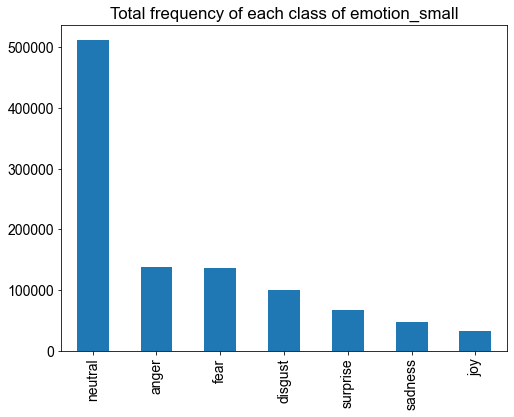

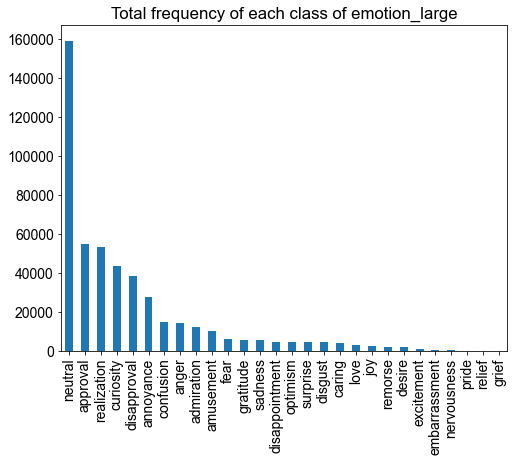

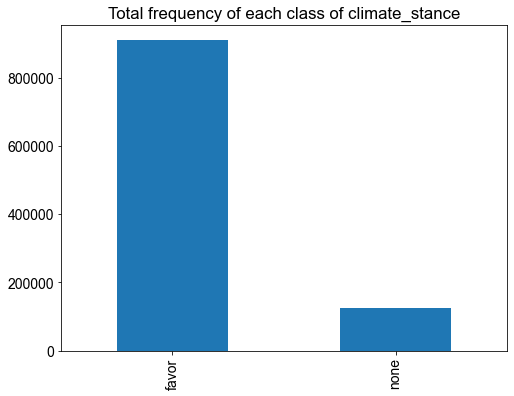

In [43]:
# Plot distribution
for label in ["emotion_small", "emotion_large", "climate_stance"]:
    df.groupby(by=label)[label].count().sort_values(ascending=False).plot.bar()
    plt.title(f"Total frequency of each class of {label}")
    plt.xlabel("")
    plt.show()

## Category distribution over time

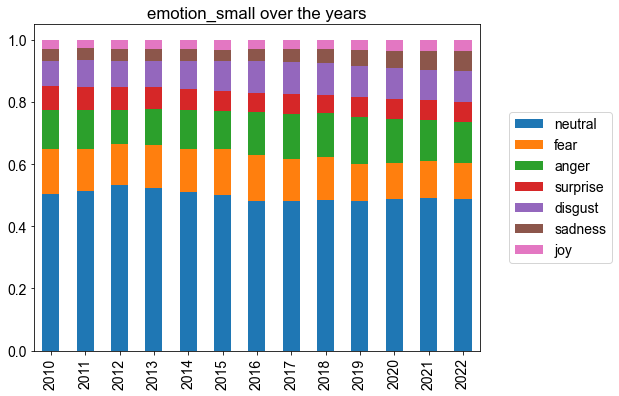

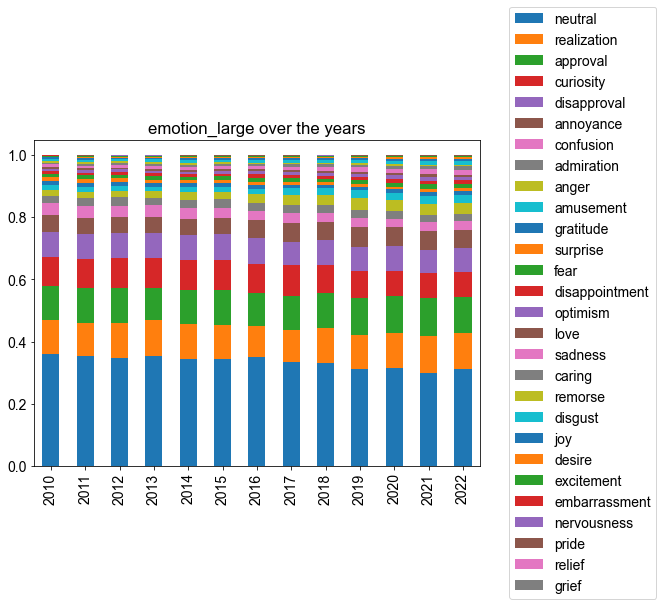

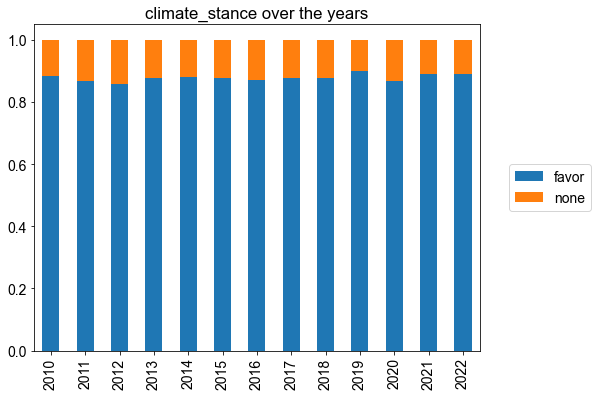

In [35]:
for label in ["emotion_small", "emotion_large", "climate_stance"]:
    distrib_time_df = df.copy().groupby(by=["created_year", label]).size().unstack(fill_value=0)
    distrib_time_df = distrib_time_df.div(distrib_time_df.sum(axis=1), axis=0) # Make y-axis relative
    distrib_time_df = distrib_time_df.sort_values(by=2010, axis=1, ascending=False)

    distrib_time_df.plot(kind='bar', stacked=True)
    plt.xlabel("")
    plt.title(f"{label} over the years")
    plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
    plt.show()

## Topic distribution per month and year

In [36]:
# Only take the most frequent topics into account, Sorting out 0 since it has too much effect on visuals, sorts our outlier topics too
topic_subset_df = df[(df["topic_number"]> 0) & (df["topic_number"]<= 10)]

In [37]:
# Check for Na values
topic_subset_df.isna().sum().sum()

0

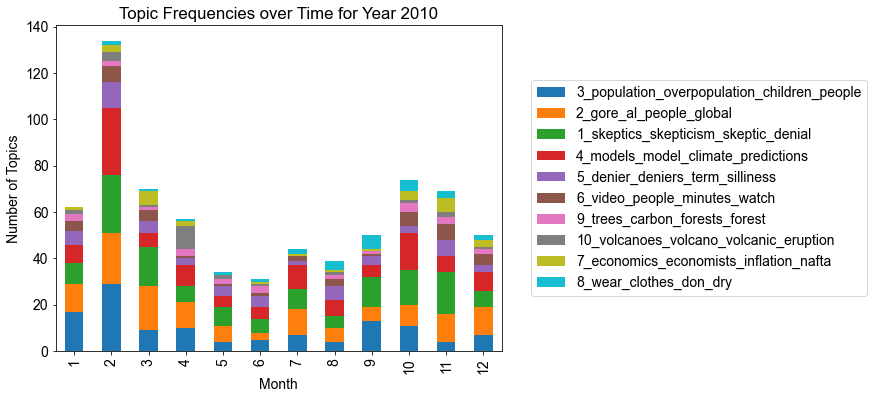

In [40]:
# Create plot for every year
for year in range (2010, 2023):

    # filter the DataFrame to include only the specified year
    df_temp = topic_subset_df[topic_subset_df['created_year'] == year]

    # aggregate the data by date and topic number
    counts = df_temp.groupby(['created_month', 'topic_name']).size().unstack(fill_value=0)
    #counts = counts.div(counts.sum(axis=1), axis=0) # Make y-axis relative
    counts = counts.sort_values(by=1, axis=1, ascending=False)

    # plot the stacked bar chart
    counts.plot(kind='bar', stacked=True)
    plt.xlabel('Month')
    plt.ylabel('Number of Topics')
    plt.title(f'Topic Frequencies over Time for Year {year}')
    plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
    plt.show()
    break # uncomment this to get all years